In [3]:
from kitaev_ladder_snake1 import run_atomic, save_after_run, load_data

In [4]:
import numpy as np
from utility import linspace

Test

In [5]:
L = 20
Jx = 1.75
Jy = 0.25
Jz = 1.0
chi = 128

result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, chi=chi, L=L, bc='periodic', bc_MPS='finite')

Reading 'L'=20 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.75 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.25 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  128 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [9]:

import warnings
import matplotlib.pyplot as plt
from random import choice
import scipy.sparse as sparse

import tenpy
from tenpy.networks.site import Site, SpinHalfFermionSite, SpinHalfSite, GroupedSite, SpinSite
from tenpy.tools.misc import to_iterable, to_iterable_of_len, inverse_permutation
from tenpy.networks.mps import MPS  # only to check boundary conditions

from tenpy.models.lattice import Lattice, _parse_sites
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.tools.params import get_parameter

from tenpy.algorithms import dmrg
# from tenpy.networks import SpinHalfSite

# some api for the file operation
import h5py
from tenpy.tools import hdf5_io
import os.path

# functools
from functools import wraps

# path
from pathlib import Path

from kitaev_ladder_snake1 import KitaevLadderSnakeCompactModel

In [13]:
""" 
    The fundamental function for running DMRG
"""
# model parameters
# chi=30, 
# Jx=1., 
# Jy=1., 
# Jz=0.,

# L=4,    
def get_first_two_low_lying(L):
    result = run_atomic(Jx=Jx, Jy=Jy, Jz=Jz, chi=chi, L=L, bc='periodic', bc_MPS='finite')
    psi0 = result['psi'].copy()
    e0 = result['energy']
    
    S=.5
    bc='periodic'
    bc_MPS='finite'
    # dmrg parametersc
    # initial_psi=None, # input psi
    # initial='random', 
    max_E_err=1.e-6
    max_S_err=1.e-4
    max_sweeps=200
    N_sweeps_check=10
    canonicalized=True
    # control for the verboe output
    verbose=1
    #######################
    # set the paramters for model initialization
    model_params = dict(
        conserve=None, 
        Jx=Jx, 
        Jy=Jy, 
        Jz=Jz, 
        L=L, 
        S=S,
        verbose=verbose,
        bc=bc,
        bc_MPS=bc_MPS,
        )
    # initialize the model
    M = KitaevLadderSnakeCompactModel(model_params)
    # providing a product state as the initial state
    # prod_state = ["up", "up"] * (2 * model_params['L'])
    # random generated initial state
    prod_state = [ choice(["up", "down"]) for i in range(2 * L)]
    psi = MPS.from_product_state(
            M.lat.mps_sites(), 
            prod_state, 
            bc=M.lat.bc_MPS,
        )
    #######################


    #######################
    # set the parameters for the dmrg routine
    dmrg_params = {
        'start_env': 10,
    #         'mixer': False,  # setting this to True helps to escape local minima
        'mixer': True,
        'mixer_params': {
            'amplitude': 1.e-4,
            'decay': 1.2,
            'disable_after': 50
        },
        'trunc_params': {
            'chi_max': 4,
            'svd_min': 1.e-10,
        },
        'max_E_err': max_E_err,
        'max_S_err': max_S_err,
        'max_sweeps': max_sweeps,
        'N_sweeps_check': N_sweeps_check,
        'verbose': verbose,
        'orthogonal_to': [result['psi']]
    }
    #######################

    if verbose:
        print("\n")
        print("=" * 80)
        print("="*30 + "START" + "="*30)
        print("=" * 80)
        print("Chi = ", chi, '\n')

    eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    eng.reset_stats()
    eng.trunc_params['chi_max'] = chi
    info = eng.run()

    if canonicalized:
        psi.canonical_form()
        if verbose:
            print("Before the canonicalization:")
            print("Bond dim = ", psi.chi)

            print("Canonicalizing...")
            psi_before = psi.copy()


        if verbose:
            ov = psi.overlap(psi_before, charge_sector=0)
            print("The norm is: ",psi.norm)
            print("The overlap is: ", ov)
            print("After the canonicalization:")
            print("Bond dim = ", psi.chi)

        print("Computing properties")

    energy=info[0]

    if verbose:
        print("Optimizing")

    tenpy.tools.optimization.optimize(3)

    if verbose:
        print("Loop for chi=%d done." % chi)
        print("=" * 80)
        print("="*30 + " END " + "="*30)
        print("=" * 80)

    # the wave function, the ground-state energy, and the DMRG engine are all that we need
    result2 = dict(
        psi=psi.copy(),
        energy=energy,
    )
    
    return [(psi0, e0), (psi, energy)]

In [15]:
L = 2
Jx = 1.75
Jy = 0.25
Jz = 1.0
chi = 64

N_list = [2*k for k in range(2, 20)]

low_lying_list = [get_first_two_low_lying(N) for N in N_list]
    

Reading 'L'=4 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.75 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.25 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config T

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 8
Energy = -7.6973248272899015, S = nan, norm_err = 7.2e-01
Current memory usage 374.1 MB, time elapsed: 3.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1435e-20, max_E_trunc = 7.9936e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 20, age = 8
Energy = -7.6973248272898944, S = nan, norm_err = 3.9e-01
Current memory usage 374.1 MB, time elapsed: 8.1 s
Delta E = 7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7930e-20, max_E_trunc = 1.3323e-14
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 8
Energy = -7.6973248272898900, S = 1.2956354128408691, norm_err = 1.4e-02
Current memory usage 374.1 MB, time elapsed: 11.2 s
Delta E = 4.4409e-16, Delta S = nan (per sweep)
max_trunc_err = 0.0000e+00, max_E_trunc = 1.1546e-14
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 40, age = 8
Energy = -7.6973248272898962, S = 1.2999595938354738, norm_err = 3

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 12
Energy = -11.5738555647460934, S = nan, norm_err = 4.4e-11
Current memory usage 374.1 MB, time elapsed: 7.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5143e-20, max_E_trunc = 1.4211e-14
MPS bond dimensions: [2, 4, 8, 12, 20, 25, 20, 14, 8, 4, 2]
sweep 20, age = 12
Energy = -11.5738555647460917, S = nan, norm_err = 1.1e-13
Current memory usage 374.1 MB, time elapsed: 13.1 s
Delta E = 1.7764e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2413e-20, max_E_trunc = 2.4869e-14
MPS bond dimensions: [2, 4, 8, 12, 19, 25, 19, 13, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 12
Energy = -11.5738555647461165, S = 1.3058138663994912, norm_err = 7.3e-14
Current memory usage 374.1 MB, time elapsed: 15.8 s
Delta E = -2.4869e-15, Delta S = nan (per sweep)
max_trunc_err = 1.1607e-30, max_E_trunc = 7.1054e-15
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 16, 8, 8, 4, 2]
sweep 40, age = 12
Energy = -1

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1431e1b8d0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 12
Energy = -11.4811099073388565, S = nan, norm_err = 4.6e-10
Current memory usage 374.1 MB, time elapsed: 8.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0875e-17, max_E_trunc = 2.1316e-14
MPS bond dimensions: [2, 4, 8, 16, 27, 34, 21, 12, 8, 4, 2]
sweep 20, age = 12
Energy = -11.4811099073388352, S = nan, norm_err = 3.9

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 16
Energy = -15.3724245309557546, S = nan, norm_err = 5.2e-10
Current memory usage 374.1 MB, time elapsed: 9.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3712e-16, max_E_trunc = 1.5987e-14
MPS bond dimensions: [2, 4, 8, 13, 18, 32, 51, 51, 34, 23, 19, 12, 8, 4, 2]
sweep 20, age = 16
Energy = -15.3724245309557315, S = nan, norm_err = 1.5e-12
Current memory usage 374.1 MB, time elapsed: 18.4 s
Delta E = 2.3093e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0227e-16, max_E_trunc = 1.9540e-14
MPS bond dimensions: [2, 4, 8, 12, 17, 27, 43, 49, 37, 25, 20, 11, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 16
Energy = -15.3724245309557332, S = 1.3603643227360072, norm_err = 1.7e-13
Current memory usage 374.1 MB, time elapsed: 22.5 s
Delta E = -1.7764e-16, Delta S = nan (per sweep)
max_trunc_err = 3.8521e-29, max_E_trunc = 2.8422e-14
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 32, 32, 32, 16

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 16
Energy = -15.2996839611272222, S = nan, norm_err = 4.4e-08
Current memory usage 374.1 MB, time elapsed: 24.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9957e-13, max_E_trunc = 8.1712e-14
MPS bond dimensions: [2, 4, 8, 15, 29, 46, 58, 45, 60, 33, 19, 11, 8, 4, 2]
sweep 20, age = 16
Energy = -15.2996839611273518, S = nan, norm_err = 1.0e-08
Current memory usage 374.1 MB, time elapsed: 37.0 s
Delta E = -1.2967e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.2702e-14, max_E_trunc = 3.3751e-14
MPS bond dimensions: [2, 4, 8, 15, 25, 39, 55, 51, 57, 31, 17, 11, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 16
Energy = -15.2996839611274282, S = 1.3074984739708149, norm_err = 1.7e-08
Current memory usage 374.1 MB, time elapsed: 44.0 s
Delta E = -7.6383e-15, Delta S = nan (per sweep)
max_trunc_err = 3.9345e-20, max_E_trunc = 2.4869e-14
MPS bond dimensions: [2, 4, 8, 8, 16, 32, 42, 32, 44, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.75 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.25 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 20
Energy = -19.1902338280099123, S = nan, norm_err = 7.3e-10
Current memory usage 374.1 MB, time elapsed: 17.0 s
Delta E = nan, Delta S = 0.000

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f143169f250>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 20
Energy = -19.1347917718851299, S = nan, norm_err = 9.6e-05
Current memory usage 374.1 MB, time elapsed: 36.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3156e-08, max_E_trunc = 2.8116e-07
MPS bond dimensions: [2, 4, 8, 13, 18, 32, 51, 64, 64, 64, 64, 56, 36, 24, 17, 11, 8, 4, 2]
sweep 20, age = 20
Energy = -19.13479183

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 24
Energy = -23.0165190175982417, S = nan, norm_err = 2.4e-08
Current memory usage 374.1 MB, time elapsed: 24.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4624e-09, max_E_trunc = 1.3103e-08
MPS bond dimensions: [2, 4, 8, 13, 18, 27, 41, 50, 64, 64, 64, 64, 64, 64, 64, 46, 35, 27, 20, 13, 8, 4, 2]
sweep 20, age = 24
Energy = -23.0165190179646117, S = nan, norm_err = 9.1e-09
Current memory usage 374.1 MB, time elapsed: 41.0 s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1430cc81d0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 24
Energy = -22.9746514619804536, S = nan, norm_err = 3.4e-04
Current memory usage 374.1 MB, time elapsed: 41.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1958e-08, max_E_trunc = 1.0351e-07
MPS bond dimensions: [2, 4, 8, 12, 23, 32, 53, 64, 64, 64, 64, 64, 64, 64, 64, 47, 36, 26, 17, 11, 8, 4, 2]
sweep 20, age = 24
Energ

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 28
Energy = -26.8468622033998692, S = nan, norm_err = 5.6e-08
Current memory usage 374.1 MB, time elapsed: 30.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.7474e-09, max_E_trunc = 2.0623e-08
MPS bond dimensions: [2, 4, 8, 11, 23, 30, 43, 46, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 48, 37, 27, 20, 13, 8, 4, 2]
sweep 20, age = 28
Energy = -26.8468622045367198, S = nan, norm_err = 1.9e-08
Current memory usage 374.1 MB, time

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f14315bab50>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 28
Energy = -26.8118820423990947, S = nan, norm_err = 1.9e-04
Current memory usage 374.1 MB, time elapsed: 53.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1567e-07, max_E_trunc = 7.6298e-07
MPS bond dimensions: [2, 4, 8, 12, 21, 29, 39, 47, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 46, 35, 26, 18, 10, 8, 4, 2]
sweep 20

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused options for config KitaevLadderSnakeCompactModel:
['Jx', 'Jy', 'Jz', 'L', 'S', 'bc', 'bc_MPS', 'conserve']
  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 30, age = 28
Energy = -26.8118821382953598, S = 1.4436284658876397, norm_err = 6.6e-07
Current memory usage 374.1 MB, time elapsed: 93.2 s
Delta E = -1.8684e-09, Delta S = nan (per sweep)
max_trunc_err = 4.8090e-08, max_E_trunc = 7.5150e-07
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 32, 32, 16, 16, 8, 8, 4, 2]
sweep 40, age = 28
Energy = -26.8118821384440196, S = 1.4436267886386374, norm_err = 5.7e-07
Current memory usage 374.1 MB, time elapsed: 109.2 s
Delta E = -1.4866e-11, Delta S = -1.6772e-07 (per sweep)
max_trunc_err = 4.8612e-08, max_E_trunc = 7.5674e-07
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 32, 32, 16, 16, 8, 8, 4, 2]
DMRG finished after 40 sweeps.
total size = 28, maximum chi = 64
Before the canonicalization:
Bond dim =  [2, 4, 8, 8, 16, 16, 32, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 32, 32, 16, 16, 8, 8, 4, 2]
Canonicalizing...
The norm is:  1.0
The overla

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))



Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.75 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.25 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 32
Energy = -30.67923

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f143205d050>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 32
Energy = -30.6478343451909865, S = nan, norm_err = 2.9e-05
Current memory usage 374.1 MB, time elapsed: 62.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.3733e-08, max_E_trunc = 6.1734e-07
MPS bond dimensions: [2, 4, 8, 13, 20, 28, 41, 49, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 53, 38, 24, 19, 11, 8

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 36
Energy = -34.5126473939418617, S = nan, norm_err = 2.4e-07
Current memory usage 374.1 MB, time elapsed: 53.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.0889e-09, max_E_trunc = 4.0962e-08
MPS bond dimensions: [2, 4, 8, 12, 20, 29, 39, 47, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 45, 36, 23, 18, 11, 8, 4, 2]
sweep 20, age = 36
Energy = -34.5126474103387011, S = nan, norm_err = 6.4e-08
Cur

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1432363050>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 36
Energy = -34.4831388249689255, S = nan, norm_err = 1.8e-04
Current memory usage 374.1 MB, time elapsed: 78.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.0514e-08, max_E_trunc = 2.6448e-07
MPS bond dimensions: [2, 4, 8, 11, 18, 31, 53, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 49, 3

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 40
Energy = -38.3466053267234201, S = nan, norm_err = 3.6e-07
Current memory usage 374.1 MB, time elapsed: 55.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.1097e-08, max_E_trunc = 5.3530e-08
MPS bond dimensions: [2, 4, 8, 12, 17, 25, 43, 46, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 49, 39, 27, 22, 12, 8, 4, 2]
sweep 20, age = 40
Energy = -38.3466053530110216, S = nan, norm_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f14320070d0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 40
Energy = -38.3181078812327698, S = nan, norm_err = 7.1e-05
Current memory usage 374.1 MB, time elapsed: 81.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6496e-08, max_E_trunc = 1.3319e-07
MPS bond dimensions: [2, 4, 8, 13, 21, 36, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 44
Energy = -42.1808518919492101, S = nan, norm_err = 4.7e-07
Current memory usage 374.1 MB, time elapsed: 103.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4298e-08, max_E_trunc = 6.5658e-08
MPS bond dimensions: [2, 4, 8, 12, 19, 29, 39, 46, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 44, 35, 24, 19, 11, 8, 4, 2]
sweep 20, age = 44
Energy = -42.1808519242630666

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1430d5db50>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 44
Energy = -42.1528996209233568, S = nan, norm_err = 1.6e-04
Current memory usage 374.1 MB, time elapsed: 90.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6893e-08, max_E_trunc = 1.3518e-07
MPS bond dimensions: [2, 4, 8, 12, 21, 39, 60, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 48
Energy = -46.0152530411800882, S = nan, norm_err = 5.9e-07
Current memory usage 374.1 MB, time elapsed: 79.1 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.6912e-08, max_E_trunc = 1.7091e-07
MPS bond dimensions: [2, 4, 8, 10, 16, 27, 37, 48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 47, 37, 26, 22, 12, 8, 4, 2]
sweep 20, age = 48
Energy = -46.0

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f14317272d0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 48
Energy = -45.9875972546785334, S = nan, norm_err = 3.1e-03
Current memory usage 374.1 MB, time elapsed: 104.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3584e-08, max_E_trunc = 1.3768e-07
MPS bond dimensions: [2, 4, 8, 16, 28, 39, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 52
Energy = -49.8497372875868123, S = nan, norm_err = 5.6e-07
Current memory usage 374.1 MB, time elapsed: 83.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9051e-08, max_E_trunc = 1.7924e-07
MPS bond dimensions: [2, 4, 8, 10, 17, 26, 41, 49, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 46, 39, 27, 21, 13, 8, 4, 2]
sweep 20, age = 5

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1461d68890>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 52
Energy = -49.8222431742545453, S = nan, norm_err = 4.5e-05
Current memory usage 374.1 MB, time elapsed: 101.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5801e-08, max_E_trunc = 3.7933e-07
MPS bond dimensions: [2, 4, 8, 13, 21, 29, 40, 44, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 40 sweeps.
total size = 52, maximum chi = 64
Before the canonicalization:
Bond dim =  [2, 4, 8, 8, 16, 16, 32, 44, 64, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 49, 32, 16, 16, 8, 8, 4, 2]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999991+0j)
After the canonicalization:
Bond dim =  [2, 4, 8, 8, 16, 16, 32, 44, 64, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 49, 32, 16, 16, 8, 8, 4, 2]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=28 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='fi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 56
Energy = -53.6842671255819397, S = nan, norm_err = 5.5e-07
Current memory usage 374.1 MB, time elapsed: 87.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0737e-08, max_E_trunc = 1.8737e-07
MPS bond dimensions: [2, 4, 8, 11, 20, 26, 40, 50, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 45, 37, 25, 20, 12, 8, 4, 2]
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1431f95dd0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 56
Energy = -53.6568583559297210, S = nan, norm_err = 2.2e-03
Current memory usage 374.1 MB, time elapsed: 109.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1704e-07, max_E_trunc = 1.0861e-06
MPS bond dimensions: [2, 4, 8, 11, 20, 25, 39, 47, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'L'=30 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.75 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=0.25 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f14318807d0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 60
Energy = -57.4914664139674798, S = nan, norm_err = 1.1e-04
Current memory usage 374.1 MB, time elapsed: 120.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.1223e-08, max_E_trunc = 1.9198e-07
MPS bond dimensions: [2, 4, 8, 13, 26, 38, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 64
Energy = -61.3533903580940532, S = nan, norm_err = 6.3e-07
Current memory usage 374.1 MB, time elapsed: 107.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0412e-08, max_E_trunc = 1.7632e-07
MPS bond dimensions: [2, 4, 8, 12, 17, 25, 38, 45, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f14325ca590>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 64
Energy = -61.3260583051972432, S = nan, norm_err = 4.0e-04
Current memory usage 374.1 MB, time elapsed: 126.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7403e-07, max_E_trunc = 3.0351e-06
MPS bond dimensions: [2, 4, 8, 10, 20, 26, 39, 48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 68
Energy = -65.1879663122052762, S = nan, norm_err = 6.9e-07
Current memory usage 374.1 MB, time elapsed: 114.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9925e-08, max_E_trunc = 1.9017e-07
MPS bond dimensions: [2, 4, 8, 11, 20, 25, 41, 50, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1430b48750>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 68
Energy = -65.1606544634879583, S = nan, norm_err = 6.7e-07
Current memory usage 374.1 MB, time elapsed: 131.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2761e-08, max_E_trunc = 1.6861e-07
MPS bond dimensions: [2, 4, 8, 12, 23, 29, 41, 47, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 40 sweeps.
total size = 68, maximum chi = 64
Before the canonicalization:
Bond dim =  [2, 4, 8, 8, 16, 16, 32, 32, 64, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 32, 16, 8, 8, 4, 2]
Canonicalizing...
The norm is:  1.0
The overlap is:  (1.0000000000000075+0j)
After the canonicalization:
Bond dim =  [2, 4, 8, 8, 16, 16, 32, 32, 64, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 32, 16, 8, 8, 4, 2]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=36 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 72
Energy = -69.0225465921908494, S = nan, norm_err = 7.6e-07
Current memory usage 374.1 MB, time elapsed: 116.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7995e-08, max_E_trunc = 1.5337e-07
MPS bond dimensions: [2, 4, 8, 12, 20, 28, 43, 58, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f14318b5150>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 72
Energy = -68.9952383660822903, S = nan, norm_err = 2.4e-03
Current memory usage 383.9 MB, time elapsed: 162.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.0576e-08, max_E_trunc = 5.0692e-07
MPS bond dimensions: [2, 4, 8, 11, 18, 26, 39, 45, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 76
Energy = -72.8571291203559355, S = nan, norm_err = 8.0e-07
Current memory usage 385.3 MB, time elapsed: 117.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7252e-08, max_E_trunc = 1.5188e-07
MPS bond dimensions: [2, 4, 8, 11, 19, 24, 41, 48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1430add610>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 76
Energy = -72.8298278164826911, S = nan, norm_err = 9.5e-04
Current memory usage 403.0 MB, time elapsed: 146.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6594e-07, max_E_trunc = 1.1434e-06
MPS bond dimensions: [2, 4, 8, 13, 22, 36, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [23]:
e0_list = []
e1_list = []

for two_states in low_lying_list:
    state0 = two_states[0]
    state1 = two_states[1]
    
    e0_list.append(state0[1])
    e1_list.append(state1[1])
#     e_list = [state[1] for state in two_states]
#     print(e_list)

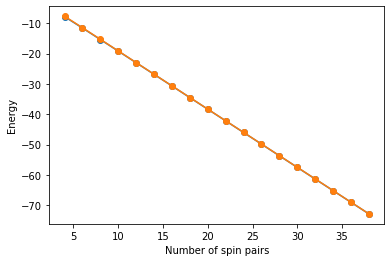

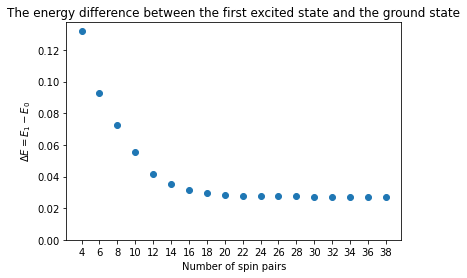

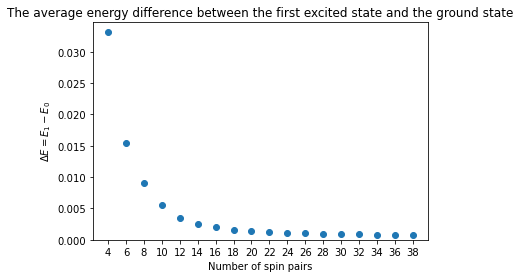

In [32]:
plt.plot(N_list, e0_list, 'o-', label='GS1')
plt.plot(N_list, e1_list, 'o-', label='GS2')
plt.xlabel('Number of spin pairs')
plt.ylabel('Energy')
plt.show()

plt.plot(N_list, [(e1_list[k] - e0_list[k]) for k in range(len(e0_list))], 'o')
plt.xticks(N_list)
plt.ylim(bottom=0)
plt.xlabel('Number of spin pairs')
plt.ylabel(r'$\Delta E = E_1 - E_0$')
plt.title('The energy difference between the first excited state and the ground state')
plt.show()

plt.plot(N_list, [(e1_list[k] - e0_list[k])/N_list[k] for k in range(len(e0_list))], 'o')
plt.xticks(N_list)
plt.ylim(bottom=0)
plt.xlabel('Number of spin pairs')
plt.ylabel(r'$\Delta E = E_1 - E_0$')
plt.title('The average energy difference between the first excited state and the ground state')
plt.show()

In [39]:
3*0.25 / (16*1.75)

0.026785714285714284

In [33]:
L = 2
Jx = 1.0
Jy = 1.0
Jz = 1.0
chi = 64

N_list = [2*k for k in range(2, 20)]

low_lying_list = [get_first_two_low_lying(N) for N in N_list]
    

Reading 'L'=4 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config Two

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 8
Energy = -6.4721359549995796, S = nan, norm_err = 1.1e+00
Current memory usage 415.0 MB, time elapsed: 1.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1726e-20, max_E_trunc = 1.4211e-14
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 20, age = 8
Energy = -6.4721359549995849, S = nan, norm_err = 6.1e-02
Current memory usage 415.0 MB, time elapsed: 3.8 s
Delta E = -5.3291e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2864e-20, max_E_trunc = 7.1054e-15
MPS bond dimensions: [2, 4, 8, 14, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 8
Energy = -6.4721359549995823, S = 1.2934737505355796, norm_err = 6.9e-01
Current memory usage 415.0 MB, time elapsed: 5.0 s
Delta E = 2.6645e-16, Delta S = nan (per sweep)
max_trunc_err = 3.2638e-30, max_E_trunc = 5.3291e-15
MPS bond dimensions: [2, 4, 8, 16, 8, 4, 2]
sweep 40, age = 8
Energy = -6.4721359549995805, S = 1.2137820716388421, norm_err = 4

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))
/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['P_tol'] for config lanczos_params

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 12
Energy = -10.1289902044919398, S = nan, norm_err = 1.4e-14
Current memory usage 415.0 MB, time elapsed: 3.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.9901e-20, max_E_trunc = 1.7764e-14
MPS bond dimensions: [2, 4, 8, 13, 22, 24, 18, 13, 8, 4, 2]
sweep 20, age = 12
Energy = -10.1289902044919451, S = nan, norm_err = 1.5e-14
Current memory usage 415.0 MB, time elapsed: 6.8 s
Delta E = -5.3291e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.6090e-20, max_E_trunc = 8.8818e-15
MPS bond dimensions: [2, 4, 8, 12, 20, 25, 17, 11, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 12
Energy = -10.1289902044919717, S = 1.3214629484577607, norm_err = 1.7e-14
Current memory usage 415.0 MB, time elapsed: 8.2 s
Delta E = -2.6645e-15, Delta S = nan (per sweep)
max_trunc_err = 2.0400e-31, max_E_trunc = 1.2434e-14
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 16, 8, 8, 4, 2]
sweep 40, age = 12
Energy = -10

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 12
Energy = -10.0000000000000000, S = nan, norm_err = 1.9e-14
Current memory usage 415.0 MB, time elapsed: 3.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.3747e-20, max_E_trunc = 1.7764e-14
MPS bond dimensions: [2, 4, 8, 11, 23, 24, 17, 12, 8, 4, 2]
sweep 20, age = 12
Energy = -10.0000000000000053, S = nan, norm_err = 1.6e-14
Current memory usage 415.0 MB, time elapsed: 7.2 s
Delta E = -5.3291e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8958e-20, max_E_trunc = 8.8818e-15
MPS bond dimensions: [2, 4, 8, 12, 19, 19, 20, 12, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 12
Energy = -9.9999999999999947, S = 1.2954582529326717, norm_err = 2.4e-14
Current memory usage 415.0 MB, time elapsed: 9.5 s
Delta E = 1.0658e-15, Delta S = nan (per sweep)
max_trunc_err = 1.4578e-30, max_E_trunc = 1.9540e-14
MPS bond dimensions: [2, 4, 8, 8, 16, 8, 16, 8, 8, 4, 2]
sweep 40, age = 12
Energy = -10.00

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 16
Energy = -13.4411324654608961, S = nan, norm_err = 2.8e-14
Current memory usage 415.0 MB, time elapsed: 5.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.3479e-17, max_E_trunc = 1.7764e-14
MPS bond dimensions: [2, 4, 8, 11, 18, 25, 42, 48, 37, 25, 22, 13, 8, 4, 2]
sweep 20, age = 16
Energy = -13.4411324654609032, S = nan, norm_err = 1.9e-14
Current memory usage 415.0 MB, time elapsed: 10.6 s
Delta E = -7.1054e-16, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0393e-16, max_E_trunc = 1.9540e-14
MPS bond dimensions: [2, 4, 8, 11, 19, 26, 43, 49, 39, 26, 22, 13, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 16
Energy = -13.4411324654609228, S = 1.3742738225467350, norm_err = 2.0e-14
Current memory usage 415.0 MB, time elapsed: 13.0 s
Delta E = -1.9540e-15, Delta S = nan (per sweep)
max_trunc_err = 4.5155e-31, max_E_trunc = 2.8422e-14
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 32, 32, 32, 1

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 16
Energy = -13.4003391852751026, S = nan, norm_err = 3.5e-14
Current memory usage 415.0 MB, time elapsed: 6.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2043e-16, max_E_trunc = 1.4211e-14
MPS bond dimensions: [2, 4, 8, 11, 19, 28, 41, 47, 37, 25, 19, 13, 8, 4, 2]
sweep 20, age = 16
Energy = -13.4003391852751133, S = nan, norm_err = 2.3e-14
Current memory usage 415.0 MB, time elapsed: 12.6 s
Delta E = -1.0658e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 9.4227e-17, max_E_trunc = 2.6645e-14
MPS bond dimensions: [2, 4, 8, 12, 18, 26, 40, 49, 37, 24, 18, 12, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 16
Energy = -13.4003391852751115, S = 1.3621610671747992, norm_err = 2.0e-14
Current memory usage 415.0 MB, time elapsed: 15.8 s
Delta E = 1.7764e-16, Delta S = nan (per sweep)
max_trunc_err = 1.2158e-30, max_E_trunc = 1.9540e-14
MPS bond dimensions: [2, 4, 8, 8, 16, 16, 32, 32, 32, 16

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 20
Energy = -16.7828700907159387, S = nan, norm_err = 3.4e-08
Current memory usage 415.0 MB, time elapsed: 8.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.6206e-09, max_E_trunc = 1.2994e-08
MPS bond dimensions: [2, 4, 8, 13, 18, 26, 40, 51, 64, 64, 64, 48, 35, 24, 18, 10, 8, 4, 2]
sweep 20, age = 20
Energy = -16.7828700907752761, S = nan, norm_err = 1.3e-08
Current memory usage 415.0 MB, time elapsed: 15.9 s
Delta E = -5.9337e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.2814e-09, max_E_trunc = 1.2972e-08
MPS bond dimensions: [2, 4, 8, 12, 20, 26, 39, 50, 64, 64, 64, 49, 36, 25, 20, 12, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 20
Energy = -16.7828701037006489, S = 1.4058580905972251, norm_err = 3.5e-14
Current memory usage 415.0 MB, time elapsed: 19.6 s
Delta E = -1.2925e-09, Delta S = nan (per sweep)
max_trunc_err = 9.4454e-31, max_E_trunc = 2.4869e-14
MPS bond dimensions: [2

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 20
Energy = -16.7692922332717558, S = nan, norm_err = 3.3e-08
Current memory usage 415.0 MB, time elapsed: 9.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.3874e-09, max_E_trunc = 7.4587e-09
MPS bond dimensions: [2, 4, 8, 12, 21, 28, 40, 50, 64, 60, 64, 50, 39, 27, 18, 13, 8, 4, 2]
sweep 20, age = 20
Energy = -16.7692922332844816, S = nan, norm_err = 9.4e-09
Current memory usage 415.0 MB, time elapsed: 18.4 s
Delta E = -1.2726e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.5306e-10, max_E_trunc = 7.4464e-09
MPS bond dimensions: [2, 4, 8, 11, 18, 26, 37, 49, 64, 64, 64, 49, 36, 26, 21, 14, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 20
Energy = -16.7692922407058234, S = 1.4004057606850993, norm_err = 3.2e-14
Current memory usage 415.0 MB, time elapsed: 23.1 s
Delta E = -7.4213e-10, Delta S = nan (per sweep)
max_trunc_err = 1.4254e-30, max_E_trunc = 2.1316e-14
MPS bond dimensions: [2

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 24
Energy = -20.1336429458205650, S = nan, norm_err = 1.1e-06
Current memory usage 415.0 MB, time elapsed: 13.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.1343e-08, max_E_trunc = 8.6677e-07
MPS bond dimensions: [2, 4, 8, 13, 18, 26, 39, 50, 64, 64, 64, 64, 64, 64, 64, 50, 37, 24, 19, 12, 8, 4, 2]
sweep 20, age = 24
Energy = -20.1336436189915311, S = nan, norm_err = 1.8e-07
Current memory usage 415.0 MB, time elapsed: 22.6 s
Delta E = -6.7317e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.4601e-08, max_E_trunc = 1.9027e-07
MPS bond dimensions: [2, 4, 8, 12, 20, 26, 41, 52, 64, 64, 64, 64, 64, 64, 64, 48, 37, 26, 19, 12, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 24
Energy = -20.1336436993075765, S = 1.4271340816863054, norm_err = 6.2e-08
Current memory usage 415.0 MB, time elapsed: 27.7 s
Delta E = -8.0316e-09, Delta S = nan (per sweep)
max_trunc_err = 9.9066e-09, max_E_trunc = 1

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 24
Energy = -20.1289892444407563, S = nan, norm_err = 9.4e-07
Current memory usage 415.0 MB, time elapsed: 14.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.2921e-08, max_E_trunc = 6.4193e-07
MPS bond dimensions: [2, 4, 8, 14, 19, 28, 39, 49, 64, 64, 64, 64, 64, 64, 64, 51, 37, 22, 19, 11, 8, 4, 2]
sweep 20, age = 24
Energy = -20.1289897309748831, S = nan, norm_err = 1.7e-07
Current memory usage 415.0 MB, time elapsed: 25.7 s
Delta E = -4.8653e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.8510e-08, max_E_trunc = 1.5282e-07
MPS bond dimensions: [2, 4, 8, 12, 21, 26, 39, 51, 64, 64, 64, 64, 64, 64, 64, 47, 37, 27, 22, 13, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 24
Energy = -20.1289898123000519, S = 1.4247535388528751, norm_err = 5.6e-08
Current memory usage 415.0 MB, time elapsed: 32.4 s
Delta E = -8.1325e-09, Delta S = nan (per sweep)
max_trunc_err = 8.0567e-09, max_E_trunc = 1

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 28
Energy = -23.4873482882210496, S = nan, norm_err = 2.0e-06
Current memory usage 415.0 MB, time elapsed: 17.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8077e-07, max_E_trunc = 1.0333e-06
MPS bond dimensions: [2, 4, 8, 11, 19, 28, 44, 50, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 48, 36, 26, 19, 12, 8, 4, 2]
sweep 20, age = 28
Energy = -23.4873488778530373, S = nan, norm_err = 6.9e-07
Current memory usage 415.0 MB, time

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1419f131d0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 28
Energy = -23.4857228404645184, S = nan, norm_err = 1.9e-06
Current memory usage 415.0 MB, time elapsed: 19.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8329e-07, max_E_trunc = 1.0724e-06
MPS bond dimensions: [2, 4, 8, 11, 20, 28, 42, 52, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 48, 38, 25, 19, 11, 8, 4, 2]
sweep 20

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 32
Energy = -26.8420399149128919, S = nan, norm_err = 2.5e-06
Current memory usage 415.0 MB, time elapsed: 22.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8949e-07, max_E_trunc = 1.1218e-06
MPS bond dimensions: [2, 4, 8, 12, 19, 29, 45, 55, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 46, 37, 25, 19, 11, 8, 4, 2]
sweep 20, age = 32
Energy = -26.8420405097097827, S = nan, norm_err = 1.3e-06
Current memory usag

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1419ee14d0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 32
Energy = -26.8414647693746566, S = nan, norm_err = 2.6e-06
Current memory usage 415.0 MB, time elapsed: 24.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9189e-07, max_E_trunc = 1.1867e-06
MPS bond dimensions: [2, 4, 8, 11, 20, 26, 44, 52, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 48, 38, 28, 22, 13, 8

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 36
Energy = -30.1970713912960349, S = nan, norm_err = 3.1e-06
Current memory usage 415.0 MB, time elapsed: 29.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9739e-07, max_E_trunc = 1.1586e-06
MPS bond dimensions: [2, 4, 8, 11, 19, 24, 40, 55, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 47, 37, 23, 18, 13, 8, 4, 2]
sweep 20, age = 36
Energy = -30.1970719613534726, S = nan, norm_err = 1.8e-06
Cur

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1419eb2fd0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 36
Energy = -30.1968660380741554, S = nan, norm_err = 3.2e-06
Current memory usage 415.0 MB, time elapsed: 30.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0420e-07, max_E_trunc = 1.2331e-06
MPS bond dimensions: [2, 4, 8, 12, 20, 29, 40, 48, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 50, 3

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 40
Energy = -33.5522220111713594, S = nan, norm_err = 3.6e-06
Current memory usage 415.0 MB, time elapsed: 36.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0139e-07, max_E_trunc = 1.1963e-06
MPS bond dimensions: [2, 4, 8, 12, 17, 25, 38, 52, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 52, 37, 25, 19, 11, 8, 4, 2]
sweep 20, age = 40
Energy = -33.5522225755989751, S = nan, norm_e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f14282092d0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 40
Energy = -33.5521482256336938, S = nan, norm_err = 3.7e-06
Current memory usage 418.5 MB, time elapsed: 35.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0656e-07, max_E_trunc = 1.2351e-06
MPS bond dimensions: [2, 4, 8, 11, 21, 28, 39, 50, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 44
Energy = -36.9074147537703539, S = nan, norm_err = 1.2e-05
Current memory usage 422.6 MB, time elapsed: 54.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0391e-07, max_E_trunc = 1.2284e-06
MPS bond dimensions: [2, 4, 8, 11, 18, 25, 40, 55, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 50, 37, 24, 19, 11, 8, 4, 2]
sweep 20, age = 44
Energy = -36.9074154937666066,

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


sweep 10, age = 44
Energy = -36.9073881896829690, S = nan, norm_err = 3.9e-06
Current memory usage 427.5 MB, time elapsed: 39.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0512e-07, max_E_trunc = 1.2385e-06
MPS bond dimensions: [2, 4, 8, 14, 21, 28, 45, 50, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 53, 37, 24, 18, 10, 8, 4, 2]
sweep 20, age = 44
Energy = -36.9073888504238710, S = nan, norm_err = 2.6e-06
Current memory usage 429.1 MB, time elapsed: 63.2 s
Delta E = -6.6074e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9059e-07, max_E_trunc = 1.2254e-06
MPS bond dimensions: [2, 4, 8, 13, 20, 29, 44, 52, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 50, 39, 25, 20, 12, 8, 4, 2]
Convergence criterium reached with enabled mixer.
disable mixer and continue
sweep 30, age = 44
Energy = -36.9073889372934332, S = 1.4763191135291704, nor

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='finite' for config KitaevLadderSnakeCompactModel
Reading 'Jx'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jy'=1.0 for config KitaevLadderSnakeCompactModel
Reading 'Jz'=1.0 for config KitaevLadderSnakeCompactModel


==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 48
Energy = -40.2626225379222902, S = nan, norm_err = 6.5e-05
Current memory usage 431.2 MB, time elapsed: 66.0 s
Delta E = nan, Delta S = 0.0000e

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f141a4ef4d0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 48
Energy = -40.2626129143913047, S = nan, norm_err = 3.9e-06
Current memory usage 438.6 MB, time elapsed: 44.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0679e-07, max_E_trunc = 1.2651e-06
MPS bond dimensions: [2, 4, 8, 12, 20, 26, 40, 49, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 52
Energy = -43.6178346410207780, S = nan, norm_err = 2.4e-04
Current memory usage 442.3 MB, time elapsed: 73.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0355e-07, max_E_trunc = 1.2482e-06
MPS bond dimensions: [2, 4, 8, 16, 32, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 63, 32, 16, 8, 4, 2]
sweep 20, age = 5

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/algorithms/dmrg.py:416: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


DMRG finished after 40 sweeps.
total size = 52, maximum chi = 64
Before the canonicalization:
Bond dim =  [2, 4, 8, 8, 16, 32, 32, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 34, 28, 16, 8, 8, 4, 2]
Canonicalizing...
The norm is:  1.0
The overlap is:  (0.9999999999999978+0j)
After the canonicalization:
Bond dim =  [2, 4, 8, 8, 16, 32, 32, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 34, 28, 16, 8, 8, 4, 2]
Computing properties
Optimizing
Loop for chi=64 done.
============================== END ==============================
Reading 'L'=26 for config KitaevLadderSnakeCompactModel
Reading 'conserve'=None for config KitaevLadderSnakeCompactModel
Reading 'S'=0.5 for config KitaevLadderSnakeCompactModel
Reading 'bc'='periodic' for config KitaevLadderSnakeCompactModel
Reading 'bc_MPS'='fi

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f141a4fccd0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 52
Energy = -43.6178332708176910, S = nan, norm_err = 4.1e-06
Current memory usage 451.4 MB, time elapsed: 49.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0358e-07, max_E_trunc = 1.2467e-06
MPS bond dimensions: [2, 4, 8, 12, 23, 26, 43, 50, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 56
Energy = -46.9730514892181077, S = nan, norm_err = 1.5e-05
Current memory usage 453.2 MB, time elapsed: 55.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0080e-07, max_E_trunc = 1.2370e-06
MPS bond dimensions: [2, 4, 8, 12, 21, 26, 41, 50, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 48, 38, 27, 18, 10, 8, 4, 2]
s

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f141a345a10>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 56
Energy = -46.9730502177038503, S = nan, norm_err = 4.3e-06
Current memory usage 463.5 MB, time elapsed: 53.5 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0111e-07, max_E_trunc = 1.2460e-06
MPS bond dimensions: [2, 4, 8, 12, 19, 26, 43, 53, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 60
Energy = -50.3282676131062843, S = nan, norm_err = 2.7e-05
Current memory usage 465.8 MB, time elapsed: 84.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9806e-07, max_E_trunc = 1.2247e-06
MPS bond dimensions: [2, 4, 8, 16, 32, 62, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 57, 30

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f141a1093d0>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 60
Energy = -50.3282674176331142, S = nan, norm_err = 4.5e-06
Current memory usage 478.4 MB, time elapsed: 58.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9830e-07, max_E_trunc = 1.2343e-06
MPS bond dimensions: [2, 4, 8, 12, 18, 26, 41, 52, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 64
Energy = -53.6834841812075965, S = nan, norm_err = 1.7e-05
Current memory usage 479.0 MB, time elapsed: 55.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9548e-07, max_E_trunc = 1.2197e-06
MPS bond dimensions: [2, 4, 8, 12, 19, 30, 41, 52, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1419ef8a90>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 64
Energy = -53.6834842607684664, S = nan, norm_err = 4.6e-06
Current memory usage 493.6 MB, time elapsed: 62.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9538e-07, max_E_trunc = 1.2178e-06
MPS bond dimensions: [2, 4, 8, 12, 19, 27, 41, 52, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 68
Energy = -57.0387010478436025, S = nan, norm_err = 4.8e-06
Current memory usage 493.6 MB, time elapsed: 58.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9261e-07, max_E_trunc = 1.1915e-06
MPS bond dimensions: [2, 4, 8, 10, 23, 31, 45, 56, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1419e97f90>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 68
Energy = -57.0387007197325246, S = nan, norm_err = 4.9e-06
Current memory usage 508.4 MB, time elapsed: 69.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0576e-07, max_E_trunc = 1.3001e-06
MPS bond dimensions: [2, 4, 8, 12, 20, 27, 41, 51, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 72
Energy = -60.3939178434150108, S = nan, norm_err = 4.9e-06
Current memory usage 509.5 MB, time elapsed: 62.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9007e-07, max_E_trunc = 1.1750e-06
MPS bond dimensions: [2, 4, 8, 12, 18, 25, 39, 51, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f14281a3590>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 72
Energy = -60.3939175188289425, S = nan, norm_err = 5.0e-06
Current memory usage 525.4 MB, time elapsed: 72.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.0393e-07, max_E_trunc = 1.2854e-06
MPS bond dimensions: [2, 4, 8, 12, 17, 27, 42, 51, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 76
Energy = -63.7491346762556006, S = nan, norm_err = 5.0e-06
Current memory usage 526.4 MB, time elapsed: 66.3 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8778e-07, max_E_trunc = 1.1670e-06
MPS bond dimensions: [2, 4, 8, 12, 18, 25, 41, 52, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))




==============================START==============================
Chi =  64 

Subconfig 'trunc_params'=Config(<3 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'orthogonal_to'=[<tenpy.networks.mps.MPS object at 0x7f1419f3b390>] for config TwoSiteDMRGEngine
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=200 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=0.0001 for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
sweep 10, age = 76
Energy = -63.7491346643556582, S = nan, norm_err = 5.0e-06
Current memory usage 543.0 MB, time elapsed: 78.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8782e-07, max_E_trunc = 1.1724e-06
MPS bond dimensions: [2, 4, 8, 11, 20, 25, 41, 54, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6

/home/jerry/anaconda3/lib/python3.7/site-packages/tenpy/tools/params.py:225: UserWarning: unused option ['start_env'] for config TwoSiteDMRGEngine

  warnings.warn(msg.format(keys=sorted(unused), name=self.name))


In [34]:
e0_list = []
e1_list = []

for two_states in low_lying_list:
    state0 = two_states[0]
    state1 = two_states[1]
    
    e0_list.append(state0[1])
    e1_list.append(state1[1])
#     e_list = [state[1] for state in two_states]
#     print(e_list)

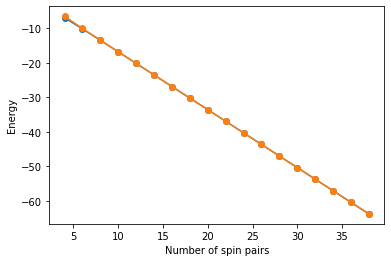

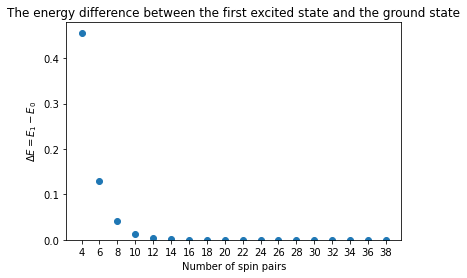

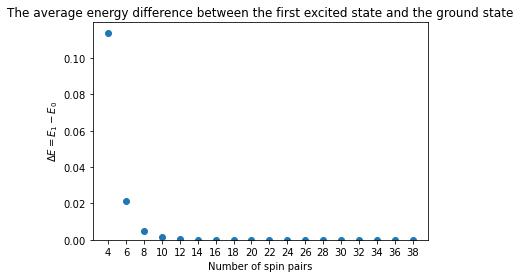

In [35]:
plt.plot(N_list, e0_list, 'o-', label='GS1')
plt.plot(N_list, e1_list, 'o-', label='GS2')
plt.xlabel('Number of spin pairs')
plt.ylabel('Energy')
plt.show()

plt.plot(N_list, [(e1_list[k] - e0_list[k]) for k in range(len(e0_list))], 'o')
plt.xticks(N_list)
plt.ylim(bottom=0)
plt.xlabel('Number of spin pairs')
plt.ylabel(r'$\Delta E = E_1 - E_0$')
plt.title('The energy difference between the first excited state and the ground state')
plt.show()

plt.plot(N_list, [(e1_list[k] - e0_list[k])/N_list[k] for k in range(len(e0_list))], 'o')
plt.xticks(N_list)
plt.ylim(bottom=0)
plt.xlabel('Number of spin pairs')
plt.ylabel(r'$\Delta E = E_1 - E_0$')
plt.title('The average energy difference between the first excited state and the ground state')
plt.show()